# Analyzing Corpora

Now that we have looked at analyzing and comparing documents, we can move to a higher unit of text. Sometime we want to look at a large collection of text in aggregate, such as the complete works of William Shakespeare, or all New York Times articles ever. The term we use for a collection of documents is corpus. And a corpus can be as large or as small as you want, but are usually collected together for some reason and have some meaning behind why they are grouped together. 

Lets look at a few examples we have direct access to through NLTK.

In [1]:
#
# Preamble
#

%matplotlib inline

# Import our core libraries
import nltk
from nltk.corpus import gutenberg
from pprint import pprint
from collections import Counter
import numpy as np
from scipy.spatial.distance import cosine
from sklearn.metrics import pairwise_distances

In [ ]:
# You can use the following to download corpora
# nltk.download()

# More info on the various corpora and corpus readers can be found here
# http://www.nltk.org/book/ch02.html

In [2]:
# Lets use a small sample of book from project gutenberg.
pprint(gutenberg.fileids())

[u'austen-emma.txt',
 u'austen-persuasion.txt',
 u'austen-sense.txt',
 u'bible-kjv.txt',
 u'blake-poems.txt',
 u'bryant-stories.txt',
 u'burgess-busterbrown.txt',
 u'carroll-alice.txt',
 u'chesterton-ball.txt',
 u'chesterton-brown.txt',
 u'chesterton-thursday.txt',
 u'edgeworth-parents.txt',
 u'melville-moby_dick.txt',
 u'milton-paradise.txt',
 u'shakespeare-caesar.txt',
 u'shakespeare-hamlet.txt',
 u'shakespeare-macbeth.txt',
 u'whitman-leaves.txt']


In [3]:
# There are 18 documents of various lengths, 
# lets get some other basic info about them
for fileid in gutenberg.fileids():
    num_words = len(gutenberg.words(fileid))
    num_sents = len(gutenberg.sents(fileid))
    num_vocab = len(set(w.lower() for w in gutenberg.words(fileid)))
    print(num_words, num_vocab, num_sents, fileid)

(192427, 7344, 7752, u'austen-emma.txt')
(98171, 5835, 3747, u'austen-persuasion.txt')
(141576, 6403, 4999, u'austen-sense.txt')
(1010654, 12767, 30103, u'bible-kjv.txt')
(8354, 1535, 438, u'blake-poems.txt')
(55563, 3940, 2863, u'bryant-stories.txt')
(18963, 1559, 1054, u'burgess-busterbrown.txt')
(34110, 2636, 1703, u'carroll-alice.txt')
(96996, 8335, 4779, u'chesterton-ball.txt')
(86063, 7794, 3806, u'chesterton-brown.txt')
(69213, 6349, 3742, u'chesterton-thursday.txt')
(210663, 8447, 10230, u'edgeworth-parents.txt')
(260819, 17231, 10059, u'melville-moby_dick.txt')
(96825, 9021, 1851, u'milton-paradise.txt')
(25833, 3032, 2163, u'shakespeare-caesar.txt')
(37360, 4716, 3106, u'shakespeare-hamlet.txt')
(23140, 3464, 1907, u'shakespeare-macbeth.txt')
(154883, 12452, 4250, u'whitman-leaves.txt')


# Document Similarity & The Vector Space Model

One thing we may want to do with our documents is see which ones are similar to other ones. This would allow us to do things like automatically group 'similar' documents, which we will do via a technique called document clustering.

A building block to automatically grouping them together (and a fun thing in its own right) is to try and see how similar one document is to another. How may we go about this? How can we __measure__ how similar one document is to another?

One way of modelling documents to support this similarity calculation is the __vector space model of documents__. It starts by imagining the document as a _bag of words_ as we saw earlier.

In [4]:
# Lets turn the text of alice in wonderland into a bag of words with
# associated frequency distribution.

alice = gutenberg.raw('carroll-alice.txt')
alice = nltk.word_tokenize(alice)
alice = [word.lower() for word in alice]
frequencies = nltk.FreqDist(alice)
print(frequencies.most_common(50))

# FreqDist docs.
# http://www.nltk.org/api/nltk.html?highlight=freqdist#nltk.probability.FreqDist

[(u',', 2418), (u'the', 1616), (u"'", 1127), (u'.', 974), (u'and', 810), (u'to', 720), (u'a', 620), (u'she', 544), (u'it', 539), (u'of', 499), (u'said', 462), (u'!', 450), (u'alice', 396), (u'was', 366), (u'i', 364), (u'in', 359), (u'you', 356), (u'that', 284), (u'--', 264), (u'as', 256), (u'her', 248), (u':', 233), (u'at', 209), (u"n't", 204), (u'?', 202), (u"'s", 194), (u';', 194), (u'on', 191), (u'had', 184), (u'with', 179), (u'all', 178), (u"'i", 169), (u'be', 148), (u'for', 146), (u'so', 144), (u'very', 139), (u'they', 135), (u'not', 135), (u'this', 131), (u'but', 131), (u'little', 128), (u'do', 125), (u'he', 117), (u'is', 113), (u'out', 113), (u'what', 103), (u'down', 102), (u'one', 99), (u'up', 97), (u'his', 95)]


## The Vector Space Model

Now if we imagine that each of the words represents a dimension in a high dimensional space. Then we each word-frequency pair represents a vector in this space, and further more the sum of those vectors gives a single vector that represents that entire document.

Here is a diagram for what that may look like for a set of documents composed entirely of two words

![Vector Space Model 2D](vector-space-2d-manning.png)
*From "Introduction to Information Retrieval", Manning et al*

In this model the frequency is known as the __term weight__ and provides the magnitude of the vector for that word. In the diagram above this has been normalzied to a score between 0 and 1. Term weight is a more general term because you can use things other than frequency as your term weight e.g. the TF-IDF score of a term.

## Cosine Similarity

Now that we have all the documents projected into a geometric space. How can we tell which documents are similar. 

One way would be to say vectors which are close to each other are similar, we could calculate the distance between two vectors and use that. However that can be problematic as documents of different lengths will have vastly different terms weights and thus skew the measure.

Another approach would be to see that vectors lines that are going in the same-ish direction are going to be more similar. So if we can compare the directions they are going we can get a sense of this. One way to do this is to calculate the angle between two vectors, the smaller than angle the more similar their direction of travel and the more similar the documents. In practice is it easier to calculate the _cosine_ of the angle between the two vectors, this produces a nice number between 0 and 1 that we can use as our similarity score

In [5]:
#Let’s create a vector space model out of some documents
#and calculate some pairwise similarities.

# Extract and normalize tokens for a given document.
def get_tokens(fileid, corpus):
    raw = corpus.raw(fileid)
    tokens = nltk.word_tokenize(raw)
    norm = [token.lower() for token in tokens]
    return norm

# Takes all the tokens that appear in token_lists and puts them in a 
# set to determine unique tokens. Then creates a dictionary mapping a token
# to its index in the set, this enables us to have a unique target position for
# each word in our vocabulary.
def build_vocabulary(token_lists):
    result = set()
    for tl in token_lists:
        result = result.union(set(tl))
    result = {v:i for i,v in enumerate(result)}
    return result

# Builds a vector for a given token list and vocabulary.
# The result is a vector with length equal to the number of words in the
# vocabulary, and term weights for each token in the token list set in 
# the appropriate position
def build_vector(tokens, vocabulary):
    result = [0] * len(vocabulary)
    freq = Counter(tokens)
    for token in tokens:
        pos = vocabulary[token]
        result[pos] = freq[token]
    return result

In [6]:
alice = get_tokens('carroll-alice.txt', gutenberg)
moby = get_tokens('melville-moby_dick.txt', gutenberg)
austen1 = get_tokens('austen-emma.txt', gutenberg)
austen2 = get_tokens('austen-persuasion.txt', gutenberg)
austen3 = get_tokens('austen-sense.txt', gutenberg)

vocabulary = build_vocabulary([alice, moby, austen1, austen2, austen3]);
print(len(vocabulary))


24588


In [7]:
alice_v = build_vector(alice, vocabulary)
moby_v = build_vector(moby, vocabulary)
austen1_v = build_vector(austen1, vocabulary)
austen2_v = build_vector(austen2, vocabulary)
austen3_v = build_vector(austen3, vocabulary)

In [8]:
print(alice_v[0:50])
print("\n")
print(list(vocabulary)[0:50])
print("\n")
print(zip(alice_v[0:50], list(vocabulary)[0:50]))

[0, 0, 0, 0, 6, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 0, 0, 0, 0]


[u'gag', u'woods', u'clotted', u'pantheistic', u'hanging', u'woody', u'disobeying', u'canes', u'scold', u'stipulate', u'medicament', u'bringing', u'wooded', u'harville', u'wooden', u'wednesday', u'broiled', u'soladoes', u'crotch', u'sooty', u'insular', u'woollen-draper', u'miniatures', u'sooth', u'sustaining', u'consenting', u"frigate's", u'inanimate', u"mind'em", u'errors', u'semicircular', u'nature.', u'cooking', u'designing', u'shocks', u'crouch', u'work-bags', u'primogenitures', u'china', u'properest', u'natured', u'climbed', u'circumferences', u'natures', u'golden', u'_would_', u'projection', u'lengthen', u'hermaphroditical', u'stern']


[(0, u'gag'), (0, u'woods'), (0, u'clotted'), (0, u'pantheistic'), (6, u'hanging'), (0, u'woody'), (0, u'disobeying'), (0, u'canes'), (0, u'scold'), (3, u'stipulate'), (2, u'medicament'), (0, u'b

In [9]:
# Lets compare Alice in Wonderland to the Others
from scipy.spatial.distance import cosine

all_vectors = [alice_v, moby_v, austen1_v, austen2_v, austen3_v]
for v in all_vectors:
    co = cosine(alice_v, v)
    print(1 - co)

1.0
0.902451480786
0.881000554468
0.893427441523
0.88611793731


In [10]:
# Lets compare Austen1 to the others
for v in all_vectors:
    co = cosine(austen1_v, v)
    print(1 - co)

0.881000554468
0.913972109401
1.0
0.971691946265
0.982561616264


In [11]:
# If we use more functionality from SciPy we can also see this all in one matrix
from sklearn.metrics import pairwise_distances

all_vectors_np = np.array(all_vectors)
similary = 1 - pairwise_distances(all_vectors_np, metric="cosine")
print(similary)

[[ 1.          0.90245148  0.88100055  0.89342744  0.88611794]
 [ 0.90245148  1.          0.91397211  0.94348224  0.92777444]
 [ 0.88100055  0.91397211  1.          0.97169195  0.98256162]
 [ 0.89342744  0.94348224  0.97169195  1.          0.98316233]
 [ 0.88611794  0.92777444  0.98256162  0.98316233  1.        ]]


# Clustering Documents

Now that we can determine which documents are similar to others, we can take advantage of a technique known as Clustering. Clustering is a machine learning technique that tries to automatically group items into a set of K sub groups (where you provide the number K). It can be used to see if there are groups that emerge out of the properties of the documents in the larger collection. Lets try clustering these documents and see if they cluster by author.

## K-Means Clustering. 

The clustering algorithm we will look at here is K-Means. There are others but K-means is relatively simple to intuitively understand. 

It works by first randomly generating some cluster centers and assigning elements to these clusters by proximity. The cluster centers are then iterateively moved to the centroid of the clustered points and the process repeated.

![Vector Space Model 2D](k-means-ng-jordan.png)

> From Stanford CS229 Lecture Notes by Andrew Ng

In [12]:
# Lets see this in action
# http://www.nltk.org/api/nltk.cluster.html
# http://www.nltk.org/_modules/nltk/cluster/kmeans.html

from nltk.cluster.kmeans import KMeansClusterer
from numpy import array

num_clusters = 3
kclusterer = KMeansClusterer(num_clusters, distance=nltk.cluster.util.cosine_distance, repeats=5)

vectors = [array(f) for f in all_vectors] 
clusters = kclusterer.cluster(vectors, True) 
print('Clustering results:', clusters)

('Clustering results:', [0, 2, 1, 1, 1])


In [13]:
# Lets do this for all 18 documents

doc_ids = gutenberg.fileids()
token_lists = [get_tokens(f, gutenberg) for f in doc_ids]
voc = build_vocabulary(token_lists)
doc_vectors = [array(build_vector(tl, voc)) for tl in token_lists]

In [17]:
num_clusters = 12 #note there are 12 authors
kclusterer = KMeansClusterer(num_clusters, distance=nltk.cluster.util.cosine_distance, repeats=25)
clusters = kclusterer.cluster(doc_vectors, True) 

doc_clusters = zip(gutenberg.fileids(), clusters)
for dc in doc_clusters:
    pprint(dc)
    
# Note that running this multiple times produces different results

(u'austen-emma.txt', 9)
(u'austen-persuasion.txt', 6)
(u'austen-sense.txt', 9)
(u'bible-kjv.txt', 11)
(u'blake-poems.txt', 7)
(u'bryant-stories.txt', 3)
(u'burgess-busterbrown.txt', 0)
(u'carroll-alice.txt', 7)
(u'chesterton-ball.txt', 4)
(u'chesterton-brown.txt', 5)
(u'chesterton-thursday.txt', 4)
(u'edgeworth-parents.txt', 10)
(u'melville-moby_dick.txt', 7)
(u'milton-paradise.txt', 8)
(u'shakespeare-caesar.txt', 1)
(u'shakespeare-hamlet.txt', 2)
(u'shakespeare-macbeth.txt', 1)
(u'whitman-leaves.txt', 8)


In [18]:
print(clusters)
kclusterer.means()

[9, 6, 9, 11, 7, 3, 0, 7, 4, 5, 4, 10, 7, 8, 1, 2, 1, 8]


[array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.5,  0. ,  0. , ...,  1. ,  0. ,  0. ]),
 array([ 0.,  4.,  0., ...,  1.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0. ,  0. ,  0. , ...,  0. ,  0.5,  0. ]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.66666667,  0.        ]),
 array([ 0.5,  0. ,  0.5, ...,  0. ,  1.5,  0. ]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  3.])]

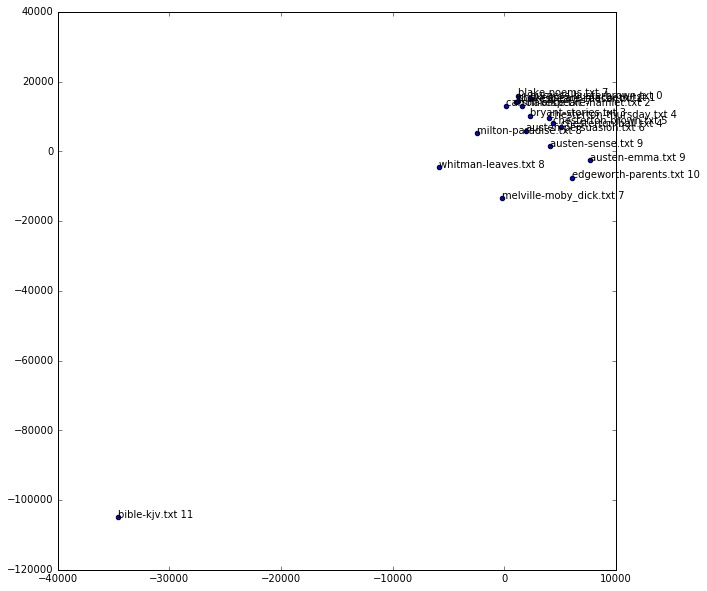

In [19]:
# MDS to plot high dimensional vectors.
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

plt.figure(figsize=(10,10)) 

mds = MDS(n_components=2, random_state=1)
pos = mds.fit_transform(doc_vectors)
xs, ys = pos[:, 0], pos[:, 1]

for x, y, name, cluster in zip(xs, ys, gutenberg.fileids(), clusters):
    color = 'blue'
    plt.scatter(x, y, c=color)
    plt.text(x, y, name + " " + str(cluster))
    
cluster_pos = mds.fit_transform(kclusterer.means())
xs, ys = cluster_pos[:, 0], pos[:, 1]

#for x, y, name in zip(xs, ys, range(num_clusters)):
#    color = 'orange'
#    plt.scatter(x, y, c=color)
#    plt.text(x, y, name)


plt.show()

## Considerations when clustering

There are a number of things to keep in mind when clustering

* Feature Selection: How you select your features (and thus build your document vectors) is very important. Feel free to experiment with different terms weights and also differing features (e.g. removing stopwords, or stemming words to their roots). Anything you can count systematically across your documents can be a feature!
* Choise of algorithm: There are many different clustering algorithms and we have only looked at two. While simple sounding, K-Means is actually widely used in production because it is relatively fast and gives pretty good results. 

## Exercises

1. Cluster the speeches in the inaugural collection, see if you can recover author distribution or maybe time/era distributions.   

In [23]:
# Exercise 1.

from nltk.corpus import inaugural

from nltk.cluster.kmeans import KMeansClusterer
from numpy import array

# Extract and normalize tokens for a given document.
def get_tokens(fileid, corpus):
    raw = corpus.raw(fileid)
    tokens = nltk.word_tokenize(raw)
    norm = [token.lower() for token in tokens]
    return norm

# Takes all the tokens that appear in token_lists and puts them in a 
# set to determine unique tokens. Then creates a dictionary mapping a token
# to its index in the set, this enables us to have a unique target position for
# each word in our vocabulary.
def build_vocabulary(token_lists):
    result = set()
    for tl in token_lists:
        result = result.union(set(tl))
    result = {v:i for i,v in enumerate(result)}
    return result

# Builds a vector for a given token list and vocabulary.
# The result is a vector with length equal to the number of words in the
# vocabulary, and term weights for each token in the token list set in 
# the appropriate position
def build_vector(tokens, vocabulary):
    result = [0] * len(vocabulary)
    freq = Counter(tokens)
    for token in tokens:
        pos = vocabulary[token]
        result[pos] = freq[token]
    return result

# The ids for the speeches. Print these out if you want to get a sense of
# what is in this corpus.
speech_names = inaugural.fileids()
print speech_names

# Step 1. Tokenize the speeches
token_lists = [get_tokens(f, inaugural) for f in speech_names]

# Step 2. Build a vocabulary for all the speeches this is the
voc = build_vocabulary(token_lists)
doc_vectors = [array(build_vector(tl, voc)) for tl in token_lists]

# list of all the features (all the terms) across the entire corpus

# Step 3. Build feature vectors for the individual speeches.  


# Step 4. Do the clustering. Feel free to pick between K-Means and GAAC. 
# How many clusters might you want to generate?

[u'1789-Washington.txt', u'1793-Washington.txt', u'1797-Adams.txt', u'1801-Jefferson.txt', u'1805-Jefferson.txt', u'1809-Madison.txt', u'1813-Madison.txt', u'1817-Monroe.txt', u'1821-Monroe.txt', u'1825-Adams.txt', u'1829-Jackson.txt', u'1833-Jackson.txt', u'1837-VanBuren.txt', u'1841-Harrison.txt', u'1845-Polk.txt', u'1849-Taylor.txt', u'1853-Pierce.txt', u'1857-Buchanan.txt', u'1861-Lincoln.txt', u'1865-Lincoln.txt', u'1869-Grant.txt', u'1873-Grant.txt', u'1877-Hayes.txt', u'1881-Garfield.txt', u'1885-Cleveland.txt', u'1889-Harrison.txt', u'1893-Cleveland.txt', u'1897-McKinley.txt', u'1901-McKinley.txt', u'1905-Roosevelt.txt', u'1909-Taft.txt', u'1913-Wilson.txt', u'1917-Wilson.txt', u'1921-Harding.txt', u'1925-Coolidge.txt', u'1929-Hoover.txt', u'1933-Roosevelt.txt', u'1937-Roosevelt.txt', u'1941-Roosevelt.txt', u'1945-Roosevelt.txt', u'1949-Truman.txt', u'1953-Eisenhower.txt', u'1957-Eisenhower.txt', u'1961-Kennedy.txt', u'1965-Johnson.txt', u'1969-Nixon.txt', u'1973-Nixon.txt', u'

## Further Reading

* [Programming Collective Intelligence by Tony Segaran](http://shop.oreilly.com/product/9780596529321.do?sortby=publicationDate) — A great lightweight and hands on introduction to various machine learning concepts such as clustering and classification.

* [Introduction to Information Retreival by Manning et Al](http://nlp.stanford.edu/IR-book/) — Online textbook covering a number of foundational topics in information retreival and statistical text processing.